<a href="https://colab.research.google.com/github/Leucocitokiller/Proyecto-Fina-NLP/blob/main/Proyecto_final_NLP_Redes_Neuronales_Libenson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Data Science III: NLP & Deep Learning aplicado a Ciencia de Datos*
# *Proyecto Final*
## *Alumno: Gabriel Libenson*
## *Comisión: 61730*


# **Introducción.**

En este trabajo práctico se aborda el análisis y clasificación de opiniones de usuarios mediante técnicas de Procesamiento de Lenguaje Natural (NLP) y Machine Learning. Se emplean dos conjuntos de datos distintos, provenientes de plataformas reconocidas: Yelp, que contiene reseñas de locales de comida, y Amazon, que incluye comentarios sobre productos.

# **Objetivos.**

El objetivo principal es desarrollar un modelo capaz de identificar automáticamente si un comentario es positivo o negativo, independientemente de la temática o sector al que pertenezca. Para ello, se aplican diferentes herramientas y técnicas propias del NLP, tales como el tokenizado, lemmatización, entre otras, que permiten transformar los textos en formatos adecuados para su análisis computacional.

Posteriormente, se prueba una variedad de modelos de machine learning para evaluar cuál es el más efectivo en la clasificación de sentimientos en ambos datasets. Esto incluye desde modelos clásicos hasta técnicas más avanzadas, buscando generalizar el aprendizaje para que el modelo pueda detectar la polaridad del comentario más allá del contexto específico.

Este enfoque facilita no solo el entendimiento de las opiniones expresadas por los usuarios, sino que también permite desarrollar sistemas automatizados de análisis de sentimientos útiles en distintas aplicaciones comerciales y de investigación.

# **Origen de los datos.**

Los datos pertenecen a una adaptación de los comentarios de yelp y amazon y fueron obtenidos del siguiente link de Github:

https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/2-Deep_Learning/PLN/Datasets/DataSetOpiniones.zip

Datos del autor:

https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/2-Deep_Learning/PLN/Datasets/readme.md



# **Desarrollo.**

# **Importación de Librerías.**

In [64]:
import urllib.request
import numpy as np
import pandas as pd
import os
import time
import sys
#-----librerias para trabajar NLP
!python -m spacy download es_core_news_md
import spacy
import es_core_news_md
#es_core_news_md Medium (modelo mediano):
#Es más pesado y más lento que el sm, pero mucho más preciso. Tiene vectores de palabras, entiende mejor el significado de las palabras.

#-----instalación d librerias para análisis de sentimientos.
!pip install spacy spacy-transformers
!pip install pysentimiento
from pysentimiento import create_analyzer

#----librerias para normalización de textos
import re
from unicodedata import normalize
import unicodedata
from collections import Counter


#----librerias para graficar y wordcloud.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#----librerías para trabajar con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
#----libreria para trabajar con BoW.
from sklearn.feature_extraction.text import CountVectorizer
#----librerias para Machine learning
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
#----librerias de Redes Neuronales.
# Importamos el Tokenizer para procesar el texto y convertirlo en secuencias numéricas
from tensorflow.keras.preprocessing.text import Tokenizer
# Importamos la función para rellenar las secuencias con ceros y asegurarnos que todas tengan la misma longitud
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
# Importamos el modelo secuencial de Keras, que permite apilar capas de manera lineal
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.regularizers import l2
# Importamos las capas necesarias:
# - Embedding: para convertir índices de palabras en vectores densos.
# - SimpleRNN: una capa recurrente que procesa secuencias de datos.
# - Dense: una capa totalmente conectada, utilizada para la salida del modelo.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 19.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **Procesamiento de la Fuente de Datos.**

## Conexión con la fuente de datos.


Se cargan dos dataset desde Github que contienen comentarios sobre celulares (Amanzon) y servicio de restaurantes (Yelp). Ambos dataset se unifican para tener un mayor volumen de datos para analizar.

Los mismos estan compuestos por dos columnas, una con los comentarios de cada usario registrado y otra con el valor asignado a ese comentario.
Si el comentario tiene un valor 1 se lo considera positivo y si tiene valor 2 como negativo.

In [2]:
# Diccionario con las fuentes y sus URLs
filepath_dict = {
    'yelp': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/yelp_comentarios.csv',
    'amazon': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/amazon_cells_comentarios.csv'

}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['Comentario', 'Valor'], sep=';', encoding='latin-1')
    df['Origen'] = source  # se agrega una nueva columna para saber si los comentarios son de Yelp o Amazon.
    df_list.append(df)

df = pd.concat(df_list)
df.head(1100)

,Comentario,Valor,Origen
0,Wow ... Me encantó este lugar.,1,yelp
1,La corteza no es buena.,0,yelp
2,No sabroso y la textura era simplemente desagr...,0,yelp
3,Me detuve durante las vacaciones de fines de m...,1,yelp
4,"La selección en el menú era genial, al igual q...",1,yelp
...,...,...,...
96,"Si planeas usar esto en un auto, olvídalo.",0,amazon
97,Encontré este producto demasiado grande.,0,amazon
98,Lo mejor que he encontrado hasta ahora ... He ...,1,amazon
99,Estoy muy decepcionado con mi decisión.,0,amazon


## Normalización de la Fuente de datos.


### Eliminación de signos de puntuación.

In [3]:
# Definición de función para eliminar los signos de puntuación utilizando re, pero considerando no borrar las vocales con acento.

def remove_punctuation(text):
    # Normaliza el texto a NFKD para separar letras y sus tildes
    text = unicodedata.normalize('NFKD', text)
    # Elimina los caracteres diacríticos (como las tildes)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Elimina todo lo que no sea letras, números o espacios
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text


# Aplicar la función a la columna 'review_lower'
df['Comentarios'] = df['Comentario'].apply(remove_punctuation)

In [4]:
df

,Comentario,Valor,Origen,Comentarios
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...
...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...


### Reducir a minúsculas el texto.

In [5]:
# Create a new column 'Comentarios_lower' with lowercase values from 'Comentario'
df['Comentarios_lower'] = df['Comentarios'].str.lower()

In [6]:
df

,Comentario,Valor,Origen,Comentarios,Comentarios_lower
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar,wow me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena,la corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...,no sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...,me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...,la seleccion en el menu era genial al igual qu...
...,...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...,la pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...,que pedazo de chatarra pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen,el articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...,lo aonico que me decepciono es el puerto infra...


### Convertir a número la columna Valor para su postprocesamiento.

In [7]:
# Convertimos la columna rating a valor numérico
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')

In [8]:
df['Valor']

,Valor
0,1
1,0
2,0
3,1
4,1
...,...
995,0
996,0
997,0
998,0


# **NLP**

## Pre Procesamiento.

### Generación del objeto de SPacy para utilizar en el procesamiento del texto en español.

Antes de aplicar técnicas de análisis de sentimiento, se debe realizar un preprocesamiento del texto que prepare los datos para ser interpretados por modelos de NLP.
En este paso, se lleva a cabo la generación del objeto de spaCy para trabajar con el idioma español, lo cual permite aprovechar herramientas lingüísticas como la tokenización, lematización

In [9]:
nlp = es_core_news_md.load()

### Convertir texto a minúsculas y Tokenización.

Una de las primeras transformaciones aplicadas es la conversión del texto a minúsculas, lo que ayuda a normalizar las palabras y evitar que el modelo interprete como diferentes aquellas que solo varían en el uso de mayúsculas (por ejemplo, "Bueno" y "bueno"). A continuación, se realiza la tokenización, que consiste en dividir el texto en unidades mínimas llamadas tokens (como palabras, signos de puntuación o números), facilitando el análisis posterior del lenguaje.

In [10]:
df['Comentarios_tokenizados'] = df['Comentarios_lower'].apply(lambda text: nlp(text))
df[['Comentarios_lower','Comentarios_tokenizados']].head()

,Comentarios_lower,Comentarios_tokenizados
0,wow me encanto este lugar,"(wow, , me, encanto, este, lugar)"
1,la corteza no es buena,"(la, corteza, no, es, buena)"
2,no sabroso y la textura era simplemente desagr...,"(no, sabroso, y, la, textura, era, simplemente..."
3,me detuve durante las vacaciones de fines de m...,"(me, detuve, durante, las, vacaciones, de, fin..."
4,la seleccion en el menu era genial al igual qu...,"(la, seleccion, en, el, menu, era, genial, al,..."


### Remoción de StopWords

Durante la eliminación de stopwords, que son palabras vacías o de bajo contenido semántico (como “el”, “la”, “y”, “de”), se identificó que en algunos casos su remoción podía afectar negativamente el sentido original de las frases. Esto es particularmente relevante en reseñas donde expresiones comunes dependen de ciertas palabras funcionales para conservar su significado completo.

Por esta razón, fue necesario generar un listado personalizado de palabras que debían conservarse.

Esto permitió preservar la coherencia y contexto de los comentarios, evitando que el modelo perdiera información clave para la detección del sentimiento.

In [11]:
# Lista de palabras que NO queremos eliminar (tienen carga emocional)
palabras_sentimiento = {
    # Positivas
    "bueno", "buena","si","buenísimo", "excelentes", "excelente", "genial", "maravilloso", "maravilla", "fantástico", "fabuloso", "increíble",
    "perfecto", "perfecta", "agradable", "satisfecho", "satisfecha", "contento", "contenta", "encantado", "encantada",
    "amable", "simpático", "simpática", "rápido", "rápida", "cómodo", "cómoda", "eficaz", "eficiente", "fácil",
    "recomendable", "ideal", "espectacular", "feliz", "brillante", "cumplió", "cumple", "funciona", "funciona bien",
    "inmejorable", "confiable", "duradero", "cumplidor", "seguro", "preciso", "elegante", "atento", "responsable",
    "acertado", "destacado", "excepcional", "impecable", "sensacional", "útil", "accesible", "económico", "funcional",
    "intuitivo", "conveniente", "hermoso", "linda", "precioso", "excelente calidad", "vale la pena",

    # Negativas
    "malo","no", "mala", "mal", "pésimo", "pésima","nunca", "horrible", "fatal", "insoportable", "lento", "lenta", "incómodo", "incómoda",
    "decepcionante", "decepcionado", "decepcionada", "sucio", "sucia", "caro", "cara", "inútil", "deficiente", "desagradable",
    "complicado", "problemático", "estafa", "engañado", "engañada", "roto", "rota", "desastroso", "error", "errores",
    "retraso", "tardanza", "frágil", "inestable", "poco fiable", "nunca más", "no volveré", "no recomiendo", "no sirve",
    "no funciona", "arruinado", "falló", "fallando", "demora", "pésima atención", "servicio malo", "mala calidad", "molesto",
    "defecto", "problemas", "fallas", "sin sentido", "basura", "pérdida de dinero", "decepción"
}

# Actualizamos spaCy para que NO considere esas palabras como stopwords
for palabra in palabras_sentimiento:
    lex = nlp.vocab[palabra]
    lex.is_stop = False

def parse_and_remove_stopwords(doc):
    """
    Remueve las stopwords de un objeto spaCy Doc.
    """
    # Filtrar stopwords y obtener los tokens como texto
    tokens_filtrados = [token.text for token in doc if not token.is_stop]
    return tokens_filtrados

# Aplicar la función al DataFrame
df['Comentarios_sin_StopWords'] = df['Comentarios_tokenizados'].apply(parse_and_remove_stopwords)

df[['Comentarios_tokenizados','Comentarios_sin_StopWords']].head()

,Comentarios_tokenizados,Comentarios_sin_StopWords
0,"(wow, , me, encanto, este, lugar)","[wow, , encanto, lugar]"
1,"(la, corteza, no, es, buena)","[corteza, no, buena]"
2,"(no, sabroso, y, la, textura, era, simplemente...","[no, sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detuve, vacaciones, fines, mayo, recomendacio..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precios]"


### Lematizado.

Se procede a aplicar la lematización, una técnica que permite reducir cada palabra a su forma base o "lema". Por ejemplo, palabras como “comprando”, “compré” o “comprarían” se transforman en “comprar”. Esto es esencial para evitar la dispersión semántica y lograr que el modelo reconozca distintas variantes de una palabra como una misma entidad.

In [12]:
def lematizar_sin_stopwords(doc):
    """
    Devuelve una lista de lemas excluyendo las stopwords.

    Parámetro:
    - doc: objeto spaCy Doc

    Retorna:
    - Lista de lemas (str) sin stopwords
    """
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar la función y guardar el resultado en una nueva columna
df['Comentarios_lema'] = df['Comentarios_tokenizados'].apply(lematizar_sin_stopwords)

df[['Comentarios_tokenizados','Comentarios_lema']].head(20)

,Comentarios_tokenizados,Comentarios_lema
0,"(wow, , me, encanto, este, lugar)","[wow, encantar, lugar]"
1,"(la, corteza, no, es, buena)","[corteza, no, buen]"
2,"(no, sabroso, y, la, textura, era, simplemente...","[no, sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detener, vacación, fines, mayo, recomendación..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precio]"
5,"(ahora, me, estoy, enojando, y, quiero, mi, ma...","[enojar, querer, maldito, pho]"
6,"(honestamente, no, sabia, tan, fresco)","[honestamente, no, sabio, fresco]"
7,"(las, papas, eran, como, caucho, y, se, notaba...","[papa, caucho, notar, habiar, preparar, tiempo..."
8,"(las, patatas, fritas, tambien, eran, geniales)","[patata, frita, genial]"
9,"(un, gran, toque)",[toque]


## Procesamiento

### Conteo de Palabras mas comunes.

Como parte del análisis exploratorio, se realizó un conteo de las palabras más frecuentes dentro de los comentarios.
Esta etapa permite identificar los términos que predominan en el lenguaje utilizado por los usuarios y detectar patrones o temas recurrentes en las opiniones.

Para un análisis más detallado, el conteo se dividió entre los comentarios de Yelp y Amazon, con el fin de comparar el vocabulario característico de cada plataforma. Mientras Yelp tiende a centrarse en experiencias relacionadas con servicios (como restaurantes o locales comerciales), Amazon refleja opiniones sobre productos, lo cual se evidencia en las diferencias léxicas observadas entre ambos conjuntos de datos.

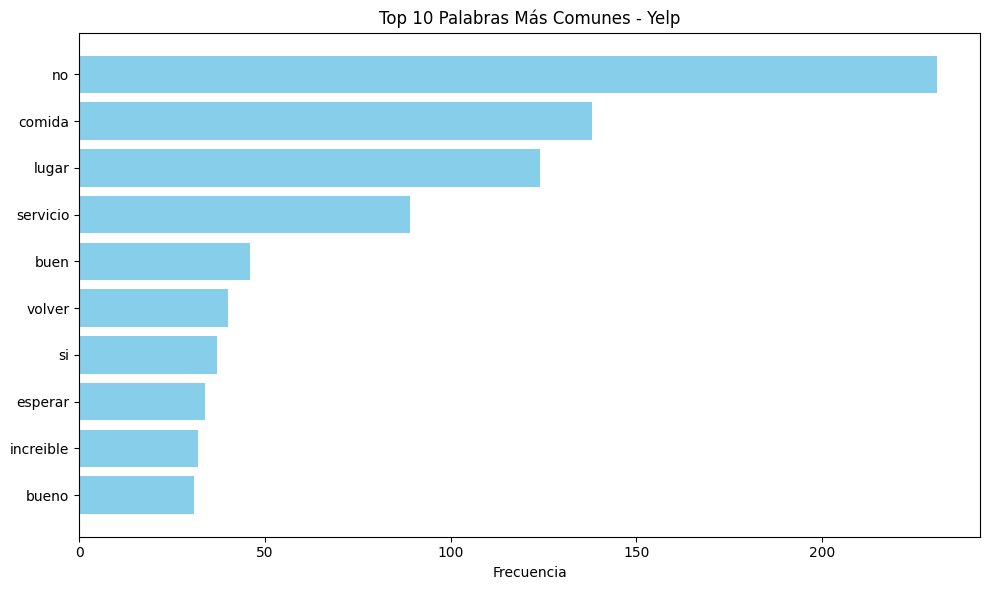

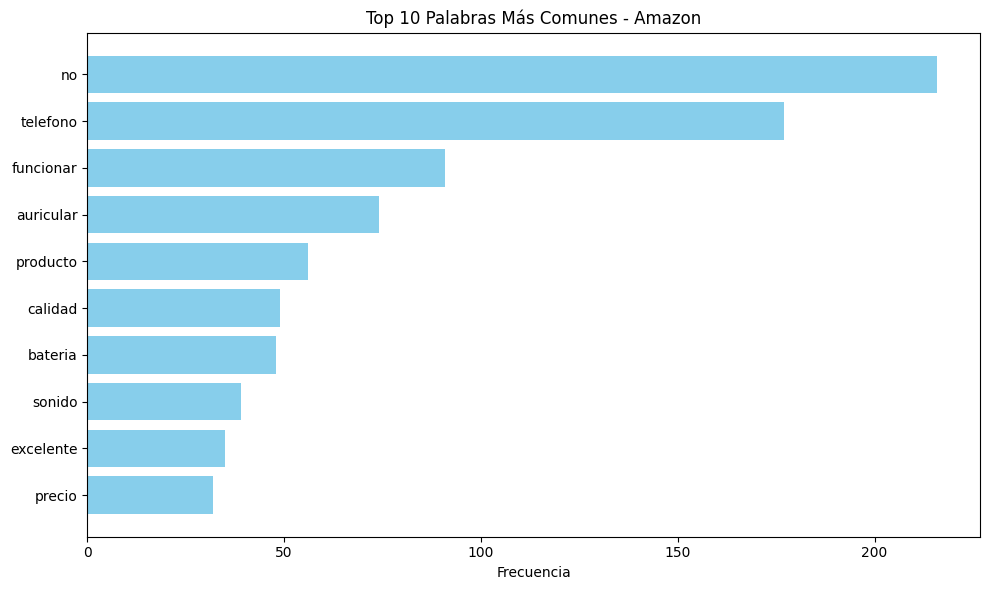

In [13]:
def graficar_palabras_comunes(df, origen, top_n=10):
    # Filtrar y aplanar los lemas
    lemas = [lema for lemas in df[df['Origen'] == origen]['Comentarios_lema'] for lema in lemas]
    conteo = Counter(lemas).most_common(top_n)

    # Separar palabras y frecuencias
    palabras, frecuencias = zip(*conteo)

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(palabras, frecuencias, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top_n} Palabras Más Comunes - {origen.capitalize()}')
    plt.gca().invert_yaxis()  # Poner la palabra más común arriba
    plt.tight_layout()
    plt.show()

# Graficar para Yelp
graficar_palabras_comunes(df, 'yelp')

# Graficar para Amazon
graficar_palabras_comunes(df, 'amazon')

### Conteo de bigramas más comunes.

Además del análisis de palabras individuales, se llevó a cabo un conteo de bigramas (pares de palabras consecutivas) con el objetivo de capturar expresiones más completas y contextuales utilizadas por los usuarios en sus comentarios. A diferencia del análisis unigram (una sola palabra), los bigramas permiten identificar frases frecuentes que pueden tener un valor semántico más claro, como "muy bueno", "no funciona", "excelente producto", entre otros.

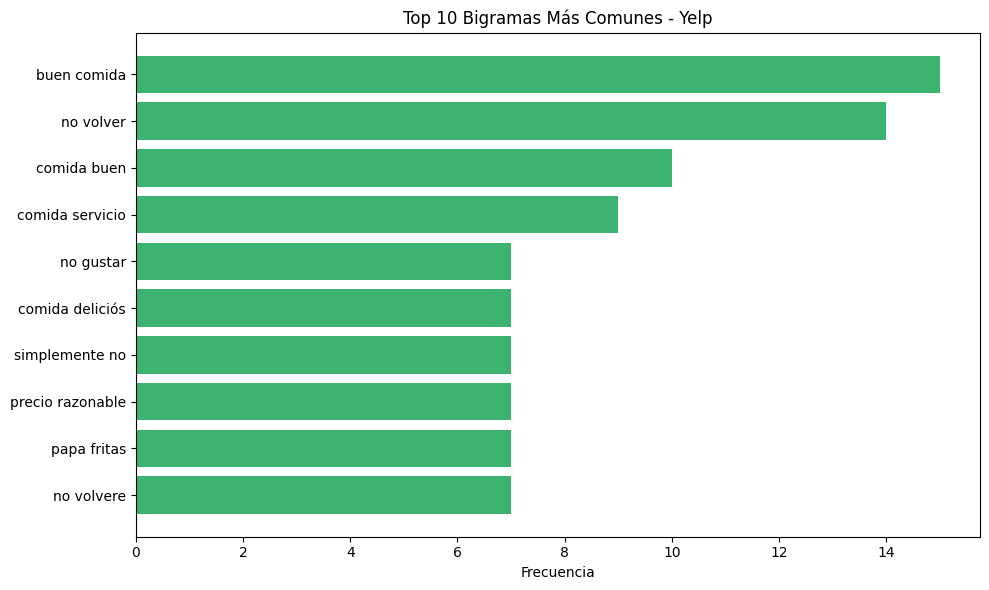

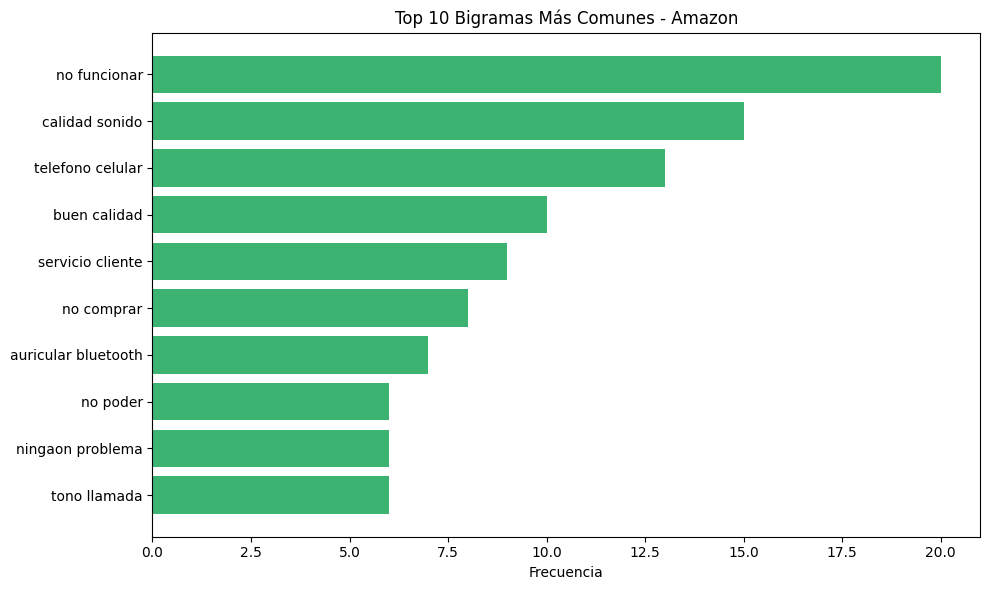

In [14]:
from collections import Counter
from itertools import tee
import matplotlib.pyplot as plt

def generar_bigramas(lista):
    """Devuelve bigramas como tuplas a partir de una lista de palabras"""
    a, b = tee(lista)
    next(b, None)
    return list(zip(a, b))

def graficar_bigramas_comunes(df, origen, top_n=10):
    # Filtrar solo los comentarios del origen y generar bigramas
    bigramas = [
        bigrama
        for lemas in df[df['Origen'] == origen]['Comentarios_lema']
        for bigrama in generar_bigramas(lemas)
    ]

    conteo = Counter(bigramas).most_common(top_n)

    # Convertir tuplas de bigramas a string para graficar
    etiquetas = [' '.join(b) for b, _ in conteo]
    frecuencias = [f for _, f in conteo]

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(etiquetas, frecuencias, color='mediumseagreen')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top_n} Bigramas Más Comunes - {origen.capitalize()}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
graficar_bigramas_comunes(df, 'yelp')
graficar_bigramas_comunes(df, 'amazon')


### WordClouds

Para complementar el análisis exploratorio, se generaron nubes de palabras que representan gráficamente la frecuencia de aparición de términos en los comentarios. Este tipo de visualización permite identificar rápidamente las palabras y frases más utilizadas por los usuarios, otorgando una vista intuitiva del contenido predominante en cada dataset.

Se realizaron dos tipos de word clouds:

Una para monogramas, es decir, palabras individuales.

Otra para bigramas, que agrupa las dos palabras consecutivas más frecuentes.

Ambos casos compara a Yelp y Amazon.

#### WordCloud Yelp.

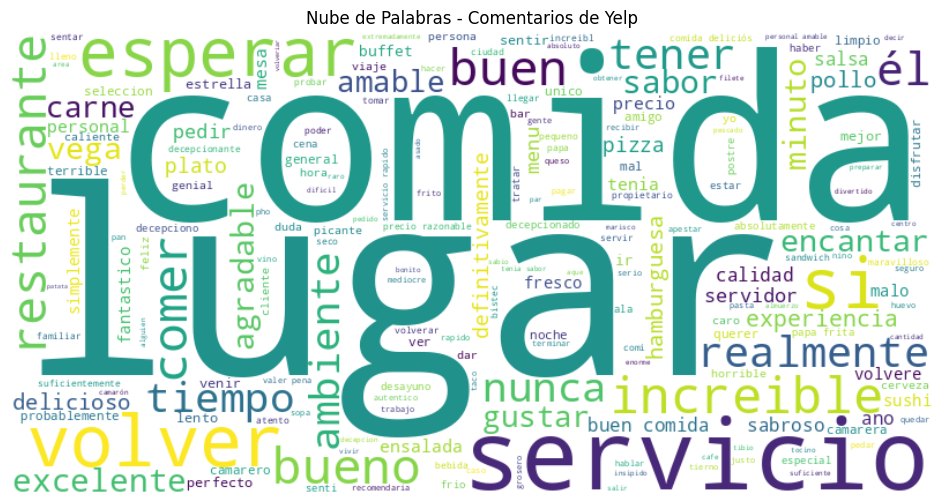

In [15]:
# Filtrar el DataFrame
df_yelp = df[df['Origen'] == 'yelp']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_yelp = ' '.join([' '.join(lemas) for lemas in df_yelp['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_yelp)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()

#### WordCloud Amazon.

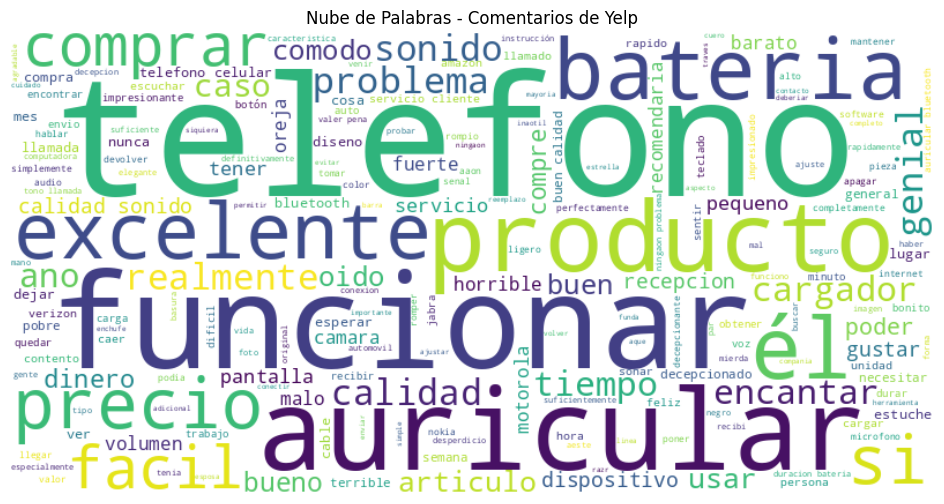

In [16]:
# Filtrar el DataFrame
df_amazon = df[df['Origen'] == 'amazon']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_amazon = ' '.join([' '.join(lemas) for lemas in df_amazon['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_amazon)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()


#### WordCloud + Bigramas.

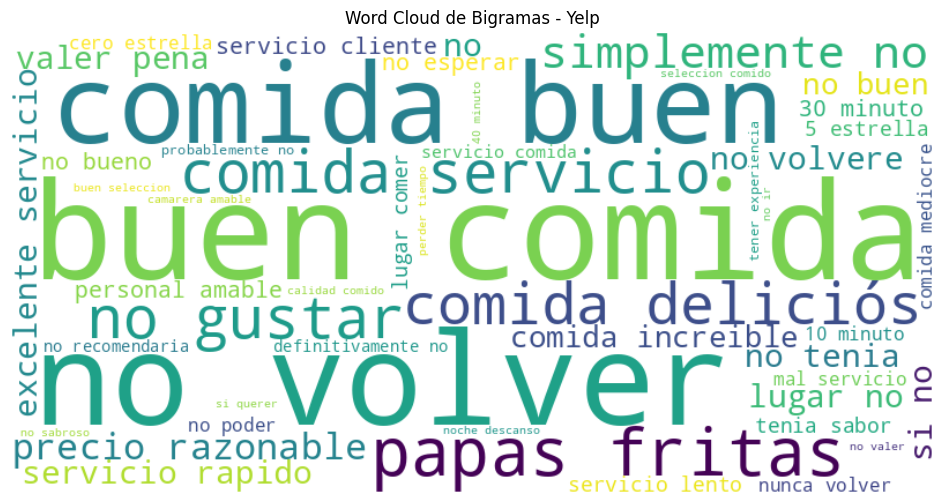

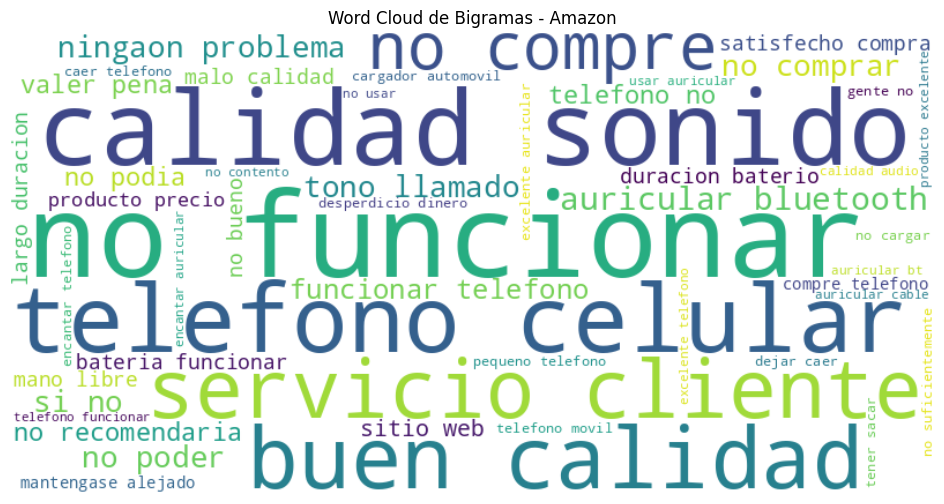

In [17]:
def generar_bigramas_spacy(df, origen, top_n=50):
    """
    Genera bigramas usando spaCy a partir de la columna 'Comentarios_Lema', sin stopwords.
    Luego genera una nube de palabras.
    """
    # Filtrar los comentarios por 'origen' (por ejemplo, 'yelp' o 'amazon')
    comentarios = df[df['Origen'] == origen]['Comentarios_sin_StopWords']

    # Generar bigramas
    bigramas = []
    for comentario in comentarios:
        # Crear un Doc de spaCy a partir de la lista de lemas (de la columna 'Comentarios_Lema')
        doc = nlp(' '.join(comentario))  # Unimos la lista de lemas y lo procesamos con spaCy
        # Extraer bigramas
        for i in range(len(doc) - 1):
            if not doc[i].is_stop and not doc[i+1].is_stop:  # Asegurarse de que no sean stopwords
                bigramas.append((doc[i].lemma_, doc[i+1].lemma_))

    # Contar los bigramas más comunes
    conteo_bigramas = Counter(bigramas).most_common(top_n)

    # Convertir los bigramas a formato texto "palabra1 palabra2"
    bigramas_texto = {' '.join(bigrama): freq for bigrama, freq in conteo_bigramas}

    # Generar la nube de palabras de los bigramas
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigramas_texto)

    # Mostrar la nube
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud de Bigramas - {origen.capitalize()}")
    plt.show()

# Generar la nube de bigramas para Yelp y Amazon
generar_bigramas_spacy(df, 'yelp')
generar_bigramas_spacy(df, 'amazon')

Word Cloud YELP.

El word cloud de bigramas extraído de reseñas en Yelp permite obtener varios insights relevantes sobre la percepción de los usuarios en relación a restaurantes o locales gastronómicos.
Puntos a destacar:

🟢 Opiniones Positivas (aunque en menor proporción):
"buen comida", "comida deliciosa", "comida increíble" y "servicio rápido" reflejan experiencias positivas, donde el sabor y la atención fueron bien valorados.

También aparecen "precio razonable", "excelente servicio", y "personal amable", lo que sugiere que algunos clientes consideran buena la relación calidad-precio y destacan la atención al cliente.

🔴 Opiniones Negativas (predominantes):
El bigrama más grande y repetido es "no volver", seguido por "no gustar", "no buen", "no valer", "nunca volver". Esto indica una tendencia fuerte de insatisfacción.

Frases como "servicio lento", "comida mediocre", "mal servicio", y "30 minuto" apuntan a problemas concretos en tiempos de espera y calidad del servicio o comida.

🟡 Insight General:
Aunque existen opiniones positivas, el peso visual y frecuencia de las expresiones negativas sugiere una tendencia mayoritaria a la insatisfacción de los usuarios. Esto podría deberse a expectativas no cumplidas, problemas de servicio, o mala calidad en algunos platos. Frases como "simplemente no", "definitivamente no", y "no recomendaría" refuerzan esta conclusión.




Word Cloud Amazon.

🔴 Opiniones Negativas (predominan fuertemente):
Los bigramas más destacados son "no funcionar", "no compre", "no recomendaría", "no poder", "no comprar" y "no cargar". Esto sugiere una fuerte insatisfacción con productos que directamente no funcionaron o presentaron fallas.

Se menciona "desperdicio dinero", "producto malo", y "manténgase alejado", lo que indica experiencias negativas muy marcadas.

La queja sobre "servicio cliente" también aparece, lo que puede reflejar problemas postventa o con la atención al consumidor.

🟢 Opiniones Positivas (en menor medida):
Hay menciones como "buen calidad", "excelente auricular", "satisfecho compra", "producto excelente", y "valer pena", lo cual sugiere que algunos usuarios sí encontraron buenos productos y experiencias satisfactorias.

También aparecen "tono llamado", "auricular bluetooth", "teléfono celular" sin una connotación explícita negativa, lo que puede referirse simplemente a términos comunes en las reseñas.

🟡 Términos neutros o a interpretar según contexto:
Bigramas como "calidad sonido", "tono llamado", "auricular bluetooth", o "batería funcionar" pueden estar dentro de contextos tanto positivos como negativos, pero su cercanía con otras frases negativas puede inclinar la interpretación hacia quejas sobre calidad de audio o duración de batería.

"sitio web", "manos libres", o "cargador automóvil" indican categorías de producto más que sentimientos específicos, pero podrían estar en el contexto de reclamos.

###🚀 Análisis de sentimiento en español con pysentimiento

Una vez preprocesados los textos, se aplicó un modelo de análisis de sentimiento específicamente entrenado para el idioma español utilizando la librería pysentimiento.

pysentimiento permite detectar si un comentario es positivo, negativo o neutral, lo cual resulta fundamental para evaluar la percepción general de los usuarios sobre un producto o servicio. A diferencia de otros enfoques más simples, este modelo considera la estructura gramatical y el significado global de la oración, lo que mejora notablemente la precisión, especialmente en expresiones ambiguas o sarcásticas.

In [18]:
# Crear analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicar a una columna de texto
df['Sentimiento'] = df['Comentario'].apply(lambda x: analyzer.predict(x).output)
# Sentimiento solo guarda lo predicho (POS, NEU o NEG)

df['Probabilidad'] = df['Comentario'].apply(lambda x: analyzer.predict(x).probas)
#Ese diccionario contiene la probabilidad de cada clase: positivo, neutro, negativo Ejemplo: {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06}.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

#### 📊  Gráfico de barras de frecuencia de sentimientos

<ipython-input-19-8869e27892cb>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')


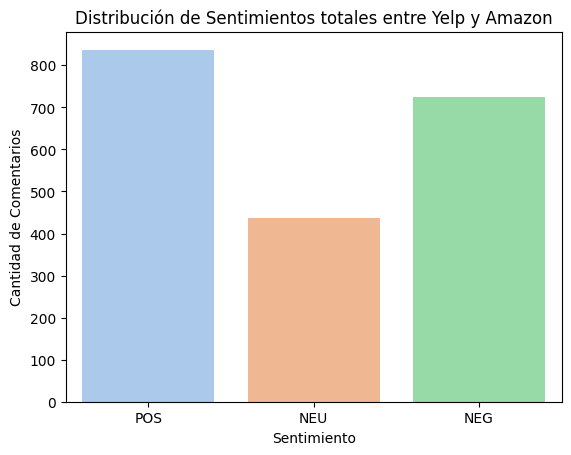

In [19]:
sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos totales entre Yelp y Amazon')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()


Se observa una distribución bastante equilibrada de sentimientos entre Positivos, Negativos y Neutros.

#### Distribución de los sentimientos.

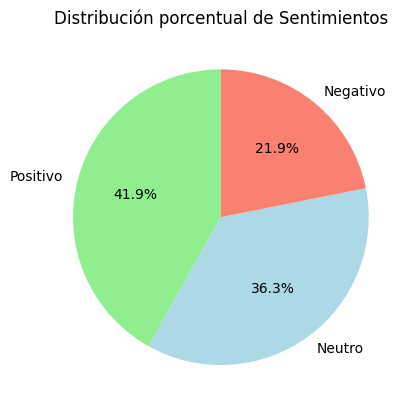

In [20]:
df['Sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['Positivo', 'Neutro', 'Negativo'],
    colors=['lightgreen', 'lightblue', 'salmon']
)
plt.title('Distribución porcentual de Sentimientos')
plt.ylabel('')
plt.show()

#### Análisis de Confianza para filtrar comentarios con baja certeza

Luego de aplicar el modelo de análisis de sentimiento con pysentimiento, se incorporó una etapa adicional para evaluar la confianza de las predicciones. Este análisis se basa en las probabilidades asignadas a cada clase (positivo, negativo o neutral), lo que permite identificar qué tan seguro está el modelo respecto a cada clasificación realizada.

Con esta información se implementó un filtro de confianza, excluyendo o marcando aquellos comentarios cuya predicción tiene baja certeza (por ejemplo, menor al 60%). Esta estrategia ayuda a reducir errores en el análisis general, ya que evita tomar decisiones basadas en clasificaciones inciertas o ambiguas.

Además, el análisis de confianza permite estudiar qué tipos de comentarios generan más dudas en el modelo, lo que puede ser útil para mejorar el preprocesamiento, ajustar umbrales, o incluso etiquetar manualmente ciertos casos en futuras iteraciones del modelo.

In [21]:
# Máxima probabilidad (nivel de certeza del modelo)
df['Confianza'] = df['Probabilidad'].apply(lambda x: max(x.values()))  # En este caso, de la lista {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06} sólo guarda 0.84 que es el valor mayor

# Filtrar comentarios cuya confianza sea menor a 0.6
comentarios_baja_confianza = df[df['Confianza'] < 0.6]
comentarios_alta_confianza = df[df['Confianza'] >= 0.6]
# Ver los primeros resultados
#comentarios_baja_confianza[['Comentarios', 'Sentimiento', 'Confianza']]

#### Distribución de los comentarios filtrados con mayor confianza.

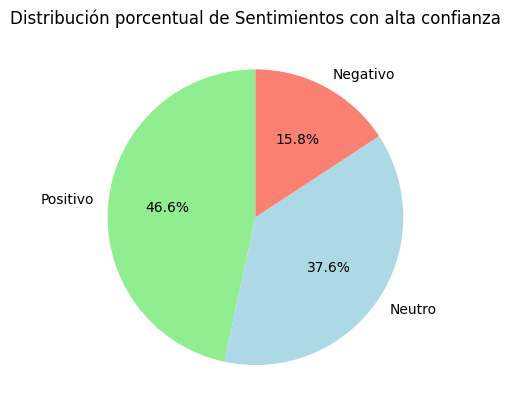

In [22]:
df[df['Confianza'] >= 0.6]['Sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['Positivo', 'Neutro', 'Negativo'],
    colors=['lightgreen', 'lightblue', 'salmon']
)
plt.title('Distribución porcentual de Sentimientos con alta confianza')
plt.ylabel('')
plt.show()

Podemos deducir que al reducirse los sentinmientos Negativos, al analizador le estaba costando interpretar ese tipo de sentimientos.

#### Distribución de la Confianza de los comentarios.

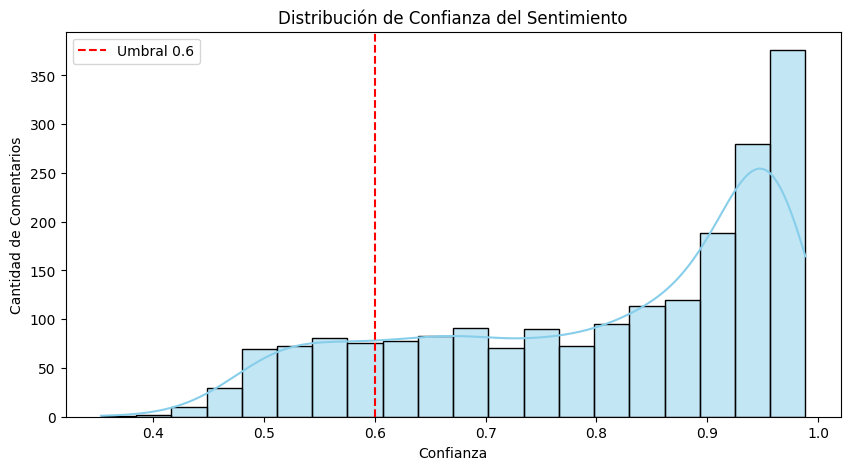

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Confianza', bins=20, kde=True, color='skyblue')
plt.axvline(0.6, color='red', linestyle='--', label='Umbral 0.6')
plt.title('Distribución de Confianza del Sentimiento')
plt.xlabel('Confianza')
plt.ylabel('Cantidad de Comentarios')
plt.legend()
plt.show()

Comentarios con baja confianza.

Los comentarios con baja probabilidad en la predicción del sentimiento (cercanos a 0.6) son especialmente valiosos en un análisis de opiniones por lo siguiente:

Ambigüedad en el lenguaje: Estos comentarios suelen contener expresiones ambiguas, mixtas o neutras, que no son claramente positivas ni negativas. Analizarlos ayuda a entender mejor los matices del lenguaje natural y las limitaciones del modelo.

Mejora del modelo: Identificar este tipo de casos permite detectar patrones lingüísticos que el modelo no logra interpretar bien. Estos ejemplos pueden ser usados para mejorar el entrenamiento futuro mediante técnicas como data augmentation o fine-tuning.

Detección de casos fronterizos: Comentarios con baja confianza son útiles para encontrar reseñas "en el límite", que podrían necesitar intervención manual o una segunda revisión, especialmente en aplicaciones críticas como moderación de contenido o evaluación de satisfacción de clientes.

Toma de decisiones más informadas: En un sistema automatizado, se pueden establecer umbrales de confianza. Por ejemplo, reseñas con probabilidad entre 0.45 y 0.55 pueden marcarse para revisión humana, lo que mejora la calidad del análisis sin revisar todo el contenido.

Calibración del modelo: Observar cómo se comporta el modelo en los casos donde no está seguro ayuda a evaluar si las probabilidades emitidas están bien calibradas o si el modelo tiende a ser demasiado confiado o conservador.


In [24]:
comentarios_baja_confianza[['Comentario', 'Sentimiento', 'Confianza', 'Probabilidad']].sort_values(by='Confianza').head(20)


,Comentario,Sentimiento,Confianza,Probabilidad
309,Â¡No esperaba que esto fuera tan bueno!,NEU,0.352952,"{'NEG': 0.30568262934684753, 'NEU': 0.35295197..."
780,Tuve una experiencia bastante satificante.,NEG,0.388925,"{'NEG': 0.38892531394958496, 'NEU': 0.32331967..."
606,Fue increible,NEU,0.412373,"{'NEG': 0.2404395341873169, 'NEU': 0.412372559..."
837,Nunca he tenido una comida tan sosa que me hay...,NEG,0.424747,"{'NEG': 0.4247467815876007, 'NEU': 0.384069591..."
527,El escudo de ruido es increible.,POS,0.428142,"{'NEG': 0.38685300946235657, 'NEU': 0.18500532..."
287,Esperamos una hora para lo que era un desayuno...,NEU,0.429849,"{'NEG': 0.36748722195625305, 'NEU': 0.42984926..."
328,AMAZON SUCHA.,NEG,0.432316,"{'NEG': 0.43231627345085144, 'NEU': 0.39011114..."
294,No sabía que el cerdo tirado podría ser tan de...,POS,0.435611,"{'NEG': 0.21574684977531433, 'NEU': 0.34864237..."
341,No estaba contento.,NEG,0.435917,"{'NEG': 0.4359167814254761, 'NEU': 0.417119354..."
365,dispositivo impresionante,NEU,0.436634,"{'NEG': 0.19049480557441711, 'NEU': 0.43663436..."


# **Pruebas de Modelos de Machine Learning.**

En este punto, se realizará un análisis de texto con el objetivo de predecir una variable numérica que nos indica positvo (para 1) y negativo (para 0), a partir de opiniones o reseñas escritas por usuarios.


Para convertir los textos en datos numéricos que puedan ser procesados por modelos de machine learning, seutilizaran dos técnicas de representación de texto:TF-IDF (Term Frequency-Inverse Document Frequency) y Bag of Words (BoW).


TF-IDF pondera la frecuencia de las palabras en cada documento ajustándola según su frecuencia inversa en todo el corpus, dando mayor peso a términos distintivos y reduciendo la influencia de palabras comunes.

Bag of Words representa cada documento como un vector que indica la frecuencia de cada palabra, sin considerar el orden ni la relevancia contextual.

Estos vectores van a ser utilizados como entrada para un modelo de regresión logística, que permitirá predecir la variable objetivo asociada a cada texto, en este caso si los comentarios son positivos o negativos.

Adicionalmente, se incorporará un modelo de deep learning utilizando la biblioteca Keras, que aprvechando redes neuronales para capturar patrones más complejos en los textos, incluyendo relaciones contextuales y secuenciales entre palabras que no pueden ser detectadas por las representaciones tradicionales.

Se entrenarán y evaluarán los tres modelos —regresión lineal con Bag of Words, regresión lineal con TF-IDF y red neuronal profunda con Keras— para comparar su desempeño predictivo.

La evaluación incluirá métricas adecuadas para regresión y análisis de generalización, con el fin de identificar cuál enfoque es más efectivo para este problema específico.

Este análisis permitirá no solo comparar técnicas clásicas y modernas de procesamiento de texto, sino también obtener insights sobre la relevancia y el impacto de las palabras y estructuras en la predicción, mejorando la comprensión del comportamiento del modelo y la calidad de las predicciones.

### División de datos de entrenamiento y prueba.

In [25]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df['Comentario'], df['Valor'], test_size=0.2, random_state=42
)

## Regresión Logística.

### Utilizando TF-IFD.

TF-IDF (Term Frequency - Inverse Document Frequency) es una técnica de procesamiento de texto utilizada para evaluar la importancia de una palabra dentro de un conjunto de documentos. Se basa en dos conceptos:

TF (Frecuencia de Término): Mide cuántas veces aparece un término en un documento específico, comparado con el número total de términos en ese documento. Esto ayuda a capturar cuán relevante es una palabra dentro de un documento en particular.

IDF (Frecuencia Inversa de Documentos): Mide la importancia de una palabra dentro de un conjunto de documentos. Si una palabra aparece en muchos documentos, tiene menos valor. La fórmula es:

Esto ayuda a reducir el peso de las palabras que aparecen frecuentemente en todos los documentos (como "el", "y", "de"), ya que no agregan mucha información.

Así, la importancia de un término en un documento depende tanto de su frecuencia en ese documento como de cuán común es en todo el conjunto de documentos.

#### Cálculo de TF-IDF con TfidVetorizer y analisis de n-gramas.

In [26]:
 # TFIDF espera trabajar con strings y  no listas, por lo que se procede a crear una nueva columna con los datos tokenizados en formato str.
df['Comentarios_sin_StopWords_str'] = df['Comentarios_sin_StopWords'].apply(lambda x: ' '.join(x))

# Crear el vectorizador
tfidfvectorizer = TfidfVectorizer(ngram_range=(1,5))
#inlcuyo bigramas y trigramas para que le de contexto a los comentarios. Esto me permite ver un "No conforme" y no solamente le "No" y el "Conforme" por separado.

# Ajustar y transformar
tfidf_matrix = tfidfvectorizer.fit_transform(df['Comentarios_sin_StopWords_str'])

# Obtener los términos
features = tfidfvectorizer.get_feature_names_out()

# Convertir la matriz a DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

# Sumar TF-IDF por columna
tfidf_scores = df_tfidf.sum().sort_values(ascending=False)

# Mostrar top 10
print("🔝 Top 10 n-gramas por score TF-IDF:")
print(tfidf_scores.head(10).round(3))




🔝 Top 10 n-gramas por score TF-IDF:
no          50.074
telefono    30.738
servicio    22.610
lugar       21.165
comida      21.084
producto    16.893
funciona    16.562
buena       14.055
calidad     11.482
precio      11.402
dtype: float64


In [27]:
# Crear un DataFrame auxiliar con el tipo de n-grama
df_scores = pd.DataFrame({
    'ngram': tfidf_scores.index,
    'score': tfidf_scores.values,
    'tipo': tfidf_scores.index.to_series().apply(lambda x: f'{len(x.split())}-grama')
})

# Ver los 5 más importantes por tipo
top_n = 5
for tipo in ['1-grama', '2-grama', '3-grama']:
    print(f"\n🔝 Top {top_n} {tipo}s:")
    print(df_scores[df_scores['tipo'] == tipo].head(top_n).to_string(index=False))


🔝 Top 5 1-gramas:
   ngram     score    tipo
      no 50.074497 1-grama
telefono 30.737920 1-grama
servicio 22.609863 1-grama
   lugar 21.165157 1-grama
  comida 21.084398 1-grama

🔝 Top 5 2-gramas:
           ngram    score    tipo
   no volveremos 4.333206 2-grama
      no volvere 4.248984 2-grama
     no funciona 3.923595 2-grama
servicio cliente 3.868002 2-grama
 no recomendaria 3.806411 2-grama

🔝 Top 5 3-gramas:
                    ngram    score    tipo
    buena comida servicio 1.494073 3-grama
    no recomendaria lugar 1.215527 3-grama
             no vale pena 1.073442 3-grama
servicio cliente terrible 1.048346 3-grama
       no compre producto 1.031673 3-grama


El análisis de los n-gramas (1, 2 y 3 palabras) revela una fuerte tendencia negativa en los comentarios analizados.

Esto se evidencia principalmente por:

La presencia dominante de la palabra "no" como unigram (1-grama) más relevante, indicando una alta frecuencia de negaciones.

Los bigramas y trigramas refuerzan esta tendencia negativa, con frases como "no volveremos", "no volvere", "no funciona", "no recomendaria", "no vale pena" y "no compre producto", todas las cuales reflejan insatisfacción o malas experiencias.

Aun así, hay menciones positivas como "buena comida servicio", pero estas son menos frecuentes o tienen menor peso que las negativas.

#### Ajuste de datos de Entrenamiento.

Ajustamos el vectorizador TF-IDF con los datos de entrenamiento y test  transformando esos datos en una matriz numérica.

In [28]:
# Ajustar y transformar los datos de entrenamiento
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
# Transformar los datos de prueba
X_test_tfidf = tfidfvectorizer.transform(X_test)

#### Generación y prueba de modelo Regresión Logística.

In [29]:
# Crear un modelo de regresión logística
# Abajo tenés un código con los parámetros expresados de forma que puedas ir modificandolos
model_log_reg = LogisticRegression() #Instanciamos el modelo

# Entrenar el modelo
model_log_reg.fit(X_train_tfidf, y_train) # Fiteamos, es decir, el modelo aprende a partir de los datos de entrenamiento

# Hacer predicciones en el conjunto de prueba
y_pred_log_reg = model_log_reg.predict(X_test_tfidf) # Predecir

#### Evaluación del Modelo.

Matriz de Confusión.

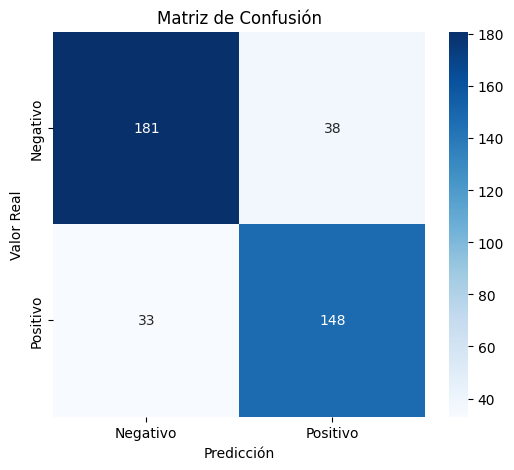

In [30]:
# 1. Matriz de confusión

# La Matriz de Confusión es útil para Muestra los aciertos y errores del modelo organizados por clase.

cm = confusion_matrix(y_test, y_pred_log_reg)
labels = ['Negativo', 'Positivo']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

📊 Interpretación de los resultados:
TP (Verdaderos Positivos) = 148: Casos positivos correctamente clasificados como positivos.

TN (Verdaderos Negativos) = 181: Casos negativos correctamente clasificados como negativos.

FP (Falsos Positivos) = 28: Casos negativos mal clasificados como positivos.

FN (Falsos Negativos) = 33: Casos positivos mal clasificados como negativos.

La matriz de confusión muestra un buen desempeño del modelo:
- 181 verdaderos negativos y 148 verdaderos positivos indican una buena capacidad para clasificar correctamente ambas clases.
- Sin embargo, hay 28 falsos positivos y 33 falsos negativos, lo que sugiere que el modelo comete algunos errores, especialmente en la identificación de la clase positiva.
- Estos errores podrían ser relevantes dependiendo del contexto del problema (por ejemplo, si detectar positivos es crítico).

Curva ROC AUC.

El ROC AUC (Receiver Operating Characteristic - Area Under Curve) es una métrica que mide la capacidad del modelo para distinguir entre clases (positiva y negativa), evaluando todas las combinaciones posibles de umbrales de clasificación.

ROC: Es una curva que grafica la tasa de verdaderos positivos (TPR) contra la tasa de falsos positivos (FPR) a distintos umbrales.

AUC (Area Under Curve): Es el área bajo esa curva, y su valor va de 0 a 1:

1.0 = modelo perfecto.

0.5 = modelo sin capacidad de clasificación (como adivinar).

< 0.5 = peor que adivinar (clasifica al revés).

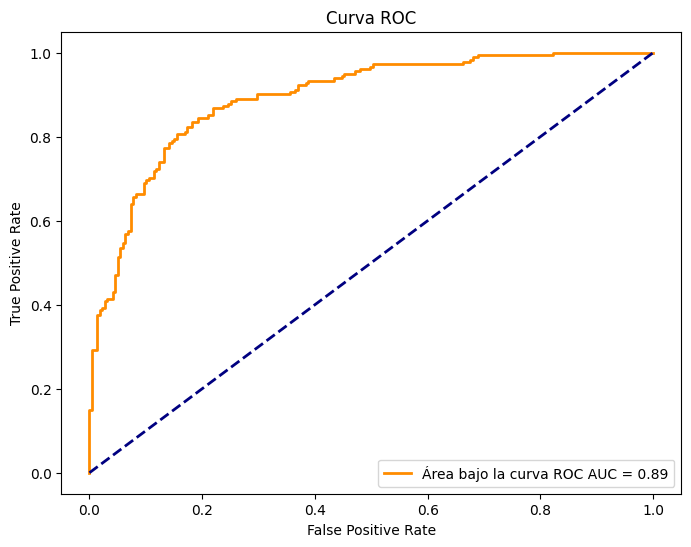

In [31]:
# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test, model_log_reg.decision_function(X_test_tfidf))
roc_auc = roc_auc_score(y_test, model_log_reg.decision_function(X_test_tfidf))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área bajo la curva ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

📈 Interpretación de tu resultado (AUC = 0.89):
El valor 0.89 indica que el modelo tiene una alta capacidad para distinguir entre clases.

En promedio, hay un 89% de probabilidad de que el modelo asigne un mayor score a una instancia positiva que a una negativa.

Este resultado sugiere que el modelo está haciendo un buen trabajo, incluso si aún hay algunos falsos positivos o falsos negativos.

Métricas de Predicción.

- Accuracy:Para medir qué tan bien predice el modelo en datos nuevos (exactitud).
Accuracy mide el porcentaje total de predicciones correctas sobre el total de casos.
- Precision: Para medir el costo de un falso positivo es alto (por ejemplo, recomendar una película mala como buena).
Precision mide qué proporción de las predicciones positivas hechas por el modelo son realmente positivas.
- Recall: Para medir cuántos de los casos positivos reales fueron capturados por el modelo.
- f1 Score: Para medir el promedio armónico entre precisión y recall. Un buen balance si ambas cosas son importantes.

In [32]:
# 3. Métricas
# Accuracy:Para medir qué tan bien predice el modelo en datos nuevos (exactitud).
# Accuracy mide el porcentaje total de predicciones correctas sobre el total de casos.
accuracy = accuracy_score(y_test, y_pred_log_reg)
# Precision: Para medir el costo de un falso positivo es alto (por ejemplo, recomendar una película mala como buena).
# Precision mide qué proporción de las predicciones positivas hechas por el modelo son realmente positivas.
precision = precision_score(y_test, y_pred_log_reg)
# Recall: Para medir cuántos de los casos positivos reales fueron capturados por el modelo.
recall = recall_score(y_test, y_pred_log_reg)
#
f1 = f1_score(y_test, y_pred_log_reg)

print("Métricas de desempeño del modelo:")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

Métricas de desempeño del modelo:
Accuracy : 0.82
Precision: 0.80
Recall   : 0.82
F1 Score : 0.81


Resultados:

- Accuracy = 0.82
El 82% de todas las predicciones (positivas y negativas) fueron correctas. Es una medida general del rendimiento.
Sin embargo, puede ser engañosa si las clases están desbalanceadas.

- Precision = 0.80
De todas las predicciones positivas que hizo el modelo, el 80% fueron realmente positivas.
Es importante si queremos minimizar falsos positivos (por ejemplo, evitar alarmas innecesarias).

- Recall = 0.82
El modelo identificó correctamente el 82% de todos los casos realmente positivos.
Es importante si queremos minimizar falsos negativos (por ejemplo, no dejar pasar casos positivos importantes).

- F1 Score = 0.81
Es el promedio armónico entre precision y recall. Resume el equilibrio entre ambos.
 Un F1 de 0.81 indica un buen balance entre identificar positivos y no equivocarse al predecirlos.


*Validación Cruzada.*

La validación cruzada es una técnica para evaluar la capacidad de generalización de un modelo. Consiste en:

Dividir los datos en k partes (folds).

Entrenar el modelo con k-1 partes y validar con la parte restante.

Repetir esto k veces, cambiando el fold de validación en cada iteración.

Calcular el promedio de las métricas obtenidas en cada iteración.

Esto reduce el riesgo de que el modelo esté sobreajustado (overfitting) a una única partición de los datos.

In [33]:
# Pipeline que junta vectorizador y modelo
pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression()
)

# Validación cruzada con 5 particiones (k-fold = 5)
scores = cross_val_score(pipeline, df['Comentario'], df['Valor'], cv=5, scoring='accuracy')

# Resultados
print(f"Precisión media con validación cruzada: {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")

Precisión media con validación cruzada: 0.807
Desviación estándar: 0.018


Resultados de la validación cruzada:

La precisión media del modelo es 0.807, lo que indica que, en promedio, el modelo acierta con un 80.7% de efectividad
en los distintos subconjuntos del conjunto de datos evaluados.

La desviación estándar es 0.018, lo que significa que el desempeño del modelo es bastante consistente entre los diferentes folds.
Es decir, no hay una gran variación en la precisión dependiendo del conjunto de entrenamiento/validación utilizado.
Estos resultados sugieren que el modelo tiene un buen rendimiento general y una buena capacidad de generalización.

Visualización de palabras asociadas a reseñas positivas y negativas.

Esta visualización permite identificar las palabras más frecuentes o relevantes en cada grupo de reseñas, separando aquellas asociadas con opiniones positivas de las relacionadas con opiniones negativas.

Al analizar estas palabras clave, podemos entender mejor qué aspectos del producto o servicio generan satisfacción o insatisfacción en los usuarios.

Este tipo de análisis ayuda a extraer insights cualitativos que complementan las métricas cuantitativas, y es muy útil para mejorar la experiencia del cliente y orientar acciones específicas de mejora.

In [34]:
# Obtenemos las palabras del vocabulario
palabras = tfidfvectorizer.get_feature_names_out()

# Coeficientes del modelo (uno por palabra)
coeficientes = model_log_reg.coef_[0]

# Creamos un DataFrame para visualizarlo
df_coef = pd.DataFrame({'palabra': palabras, 'coeficiente': coeficientes})

# Ordenamos por importancia
df_coef = df_coef.sort_values(by='coeficiente', ascending=False)

# En la primera columna veremos el número "índice" de cada palabra según el órden en que fueron procesadas en el modelo.

# Mostramos las 10 palabras más asociadas a valoración positiva y negativa
print("🔼 Palabras más asociadas a reseñas positivas:")
print(df_coef.head(10))

print("\n🔽 Palabras más asociadas a reseñas negativas:")
print(df_coef.tail(10))

🔼 Palabras más asociadas a reseñas positivas:
         palabra  coeficiente
19666       gran     2.652094
3455        buen     1.947873
17866  excelente     1.903779
27629        muy     1.677747
2959        bien     1.572698
3549       buena     1.352007
19086   funciona     1.311803
21523  increíble     1.307181
15119         es     1.260216
19484     genial     1.165134

🔽 Palabras más asociadas a reseñas negativas:
             palabra  coeficiente
32591          pobre    -0.958729
11277         dinero    -1.046398
10008  decepcionante    -1.090290
41723       terrible    -1.117921
16414         estaba    -1.156037
21104       horrible    -1.160473
34367            que    -1.229001
9992    decepcionado    -1.426818
25445           mala    -1.471687
28614             no    -4.650758


Las palabras con coeficientes positivos más altos, como "gran", "buen", "excelente", "funciona" y "increíble", están fuertemente asociadas con reseñas positivas, reflejando satisfacción, calidad y buen desempeño del producto o servicio.

En contraste, las palabras con coeficientes negativos más fuertes, como "no", "mala", "decepcionado", "horrible" y "terrible", se asocian claramente con reseñas negativas, indicando insatisfacción, problemas y decepción por parte de los usuarios.

Esto muestra que el modelo ha identificado correctamente los términos que expresan opiniones positivas y negativas, lo que facilita la interpretación y el análisis cualitativo del sentimiento en los textos.

Graficar las 10 palabras más positivas y más negativas

<ipython-input-35-b0ca5afc65f8>:36: UserWarning: Glyph 128316 (\N{UP-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-35-b0ca5afc65f8>:36: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128316 (\N{UP-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


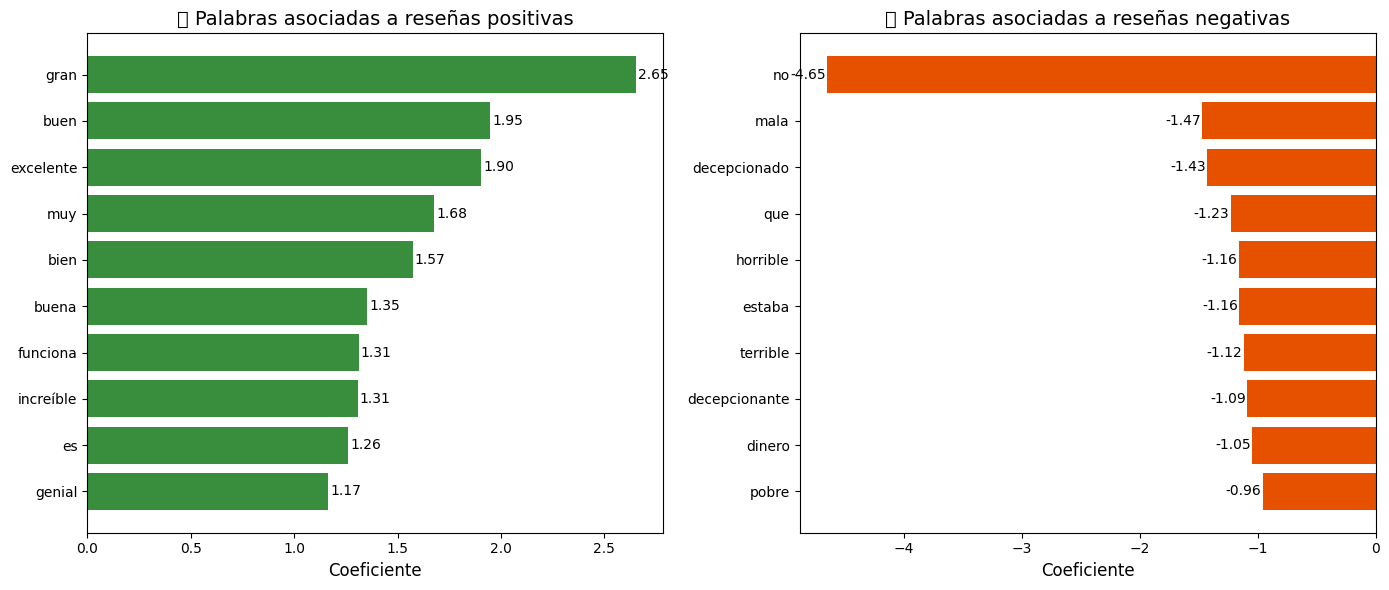

In [35]:
# Colores pastel suaves (más apagados)
color_positivas = '#388e3c'  # verde claro apagado
color_negativas = '#e65100'  # rojo claro apagado

# Top 10 positivas y negativas
top_positivas = df_coef.head(10)
top_negativas = df_coef.tail(10).sort_values(by='coeficiente')

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de palabras positivas
bars1 = ax[0].barh(top_positivas['palabra'], top_positivas['coeficiente'], color=color_positivas)
ax[0].set_title('🔼 Palabras asociadas a reseñas positivas', fontsize=14)
ax[0].invert_yaxis()
ax[0].set_xlabel('Coeficiente', fontsize=12)

# Agregar valores al final de las barras (positivas)
for bar in bars1:
    width = bar.get_width()
    ax[0].text(width + 0.01, bar.get_y() + bar.get_height() / 2,
               f'{width:.2f}', va='center', fontsize=10)

# Gráfico de palabras negativas
bars2 = ax[1].barh(top_negativas['palabra'], top_negativas['coeficiente'], color=color_negativas)
ax[1].set_title('🔽 Palabras asociadas a reseñas negativas', fontsize=14)
ax[1].invert_yaxis()
ax[1].set_xlabel('Coeficiente', fontsize=12)

# Agregar valores al final de las barras (negativas)
for bar in bars2:
    width = bar.get_width()
    ax[1].text(width - 0.01, bar.get_y() + bar.get_height() / 2,
               f'{width:.2f}', va='center', ha='right', fontsize=10)

plt.tight_layout()
plt.show()


<ipython-input-36-94115b775b5c>:23: UserWarning: Glyph 128316 (\N{UP-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-94115b775b5c>:23: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128316 (\N{UP-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


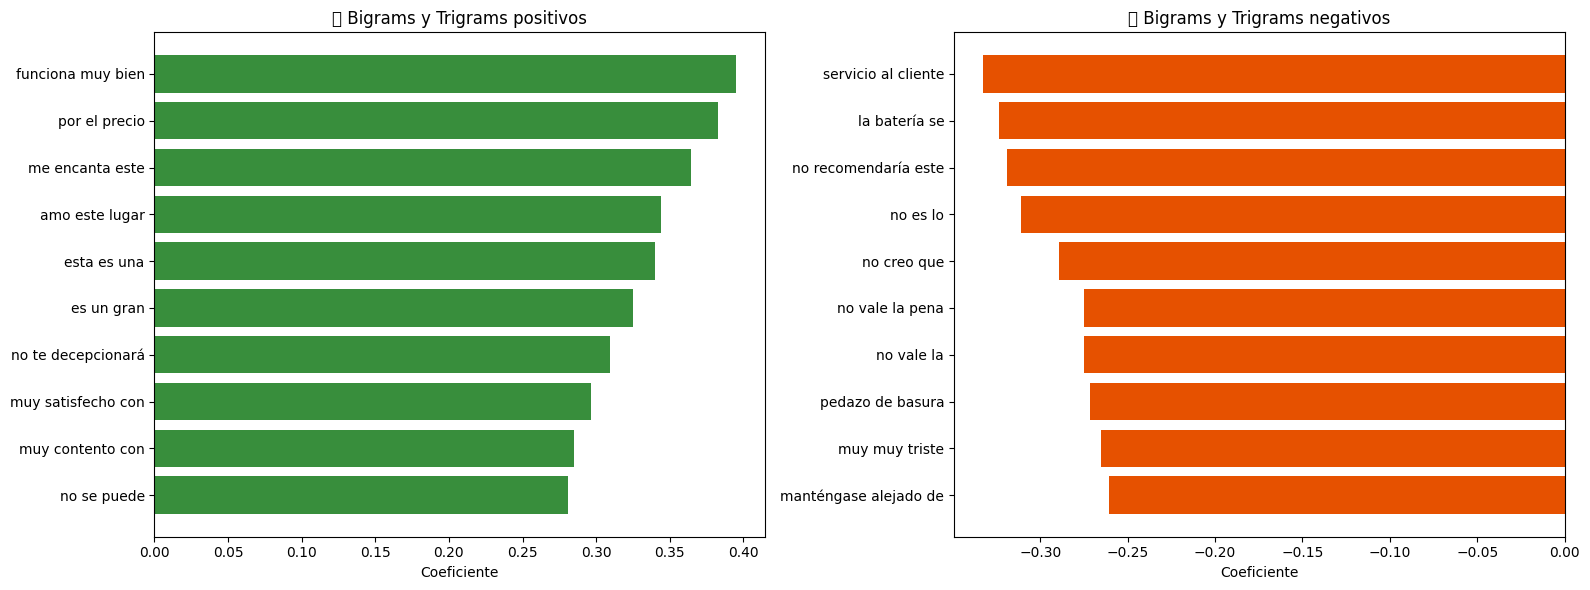

In [36]:
# Filtrar bigramas y trigramas
# Cambiar 'ngrama' a 'palabra' para acceder a la columna correcta
df_bi_tri = df_coef[df_coef['palabra'].str.count(' ') >= 2]

top_pos_bi_tri = df_bi_tri.sort_values('coeficiente', ascending=False).head(10)
top_neg_bi_tri = df_bi_tri.sort_values('coeficiente', ascending=True).head(10)

color_positivas = '#388e3c'  # verde oscuro
color_negativas = '#e65100'  # naranja oscuro

fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].barh(top_pos_bi_tri['palabra'], top_pos_bi_tri['coeficiente'], color=color_positivas) # Cambiar 'ngrama' a 'palabra'
axes[0].invert_yaxis()
axes[0].set_title('🔼 Bigrams y Trigrams positivos')
axes[0].set_xlabel('Coeficiente')

axes[1].barh(top_neg_bi_tri['palabra'], top_neg_bi_tri['coeficiente'], color=color_negativas) # Cambiar 'ngrama' a 'palabra'
axes[1].invert_yaxis()
axes[1].set_title('🔽 Bigrams y Trigrams negativos')
axes[1].set_xlabel('Coeficiente')

plt.tight_layout()
plt.show()


🧠 ¿Qué muestran los gráficos?
Las palabras con coeficientes positivos son las que más contribuyen a que el modelo prediga una reseña positiva.

Las palabras con coeficientes negativos son las que más empujan al modelo hacia una predicción negativa.

Prueba del modelo.

Se genera un código para probar distintas frases con comentarios genericos con el motivo de evaluar la funcionalidad del modelo de predicción.

In [37]:
nueva_reseña = "no lo recominedo"  # Reemplaza con la reseña que deseas probar
nueva_reseña_tfidf = tfidfvectorizer.transform([nueva_reseña])
prediccion = model_log_reg.predict(nueva_reseña_tfidf)
# Obtener la probabilidad de la predicción
probabilidadpositiva = model_log_reg.predict_proba(nueva_reseña_tfidf)

# Obtener la probabilidad en la clase predicha (0 o 1)
probabilidad = probabilidadpositiva[0][1]  # Probabilidad de la clase "positivo"

print(f"Se predice que la crítica es de caracter {prediccion[0]}")
print(f" con una probabilidad de que sea positiva de {probabilidad:.2f}")

Se predice que la crítica es de caracter 0
 con una probabilidad de que sea positiva de 0.09


### Utilizando Bag of Words.

BoW convierte un conjunto de documentos en una matriz de ocurrencias de palabras. A diferencia de TF-IDF, que pondera las palabras según su frecuencia e importancia en relación con todo el corpus, BoW solo cuenta cuántas veces aparece una palabra en un documento sin considerar la frecuencia global de la palabra.

#### Ajuste de datos de entrenamiento para BoW.

In [38]:
# Instanciamos el vectorizador BoW
vectorizer_bow = CountVectorizer()

# Aplicamos el vectorizador a los comentarios lematizados (ahora en formato string)
vector_bow = vectorizer_bow.fit_transform(df['Comentarios_sin_StopWords_str'])

# Convertimos la matriz de características en un DataFrame para visualizar
bow_df = pd.DataFrame(vector_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

# Obtener los nombres de las características (palabras)
features_bow = vectorizer_bow.get_feature_names_out()


# Crear un DataFrame con las frecuencias de las palabras
df_bow = pd.DataFrame(vector_bow.toarray(), columns=features_bow)

In [39]:
# Ajustar y transformar los datos de entrenamiento
X_train_bow = vectorizer_bow.fit_transform(X_train)
# Transformar los datos de prueba
X_test_bow  = X_test_bow  = vectorizer_bow.transform(X_test)

Generación y prueba del Modelo con BoW.

In [40]:
# Crear un modelo de regresión logística
# Abajo tenés un código con los parámetros expresados de forma que puedas ir modificandolos
model_log_reg_Bow = LogisticRegression() #Instanciamos el modelo

# Entrenar el modelo
model_log_reg_Bow.fit(X_train_bow, y_train) # Fiteamos, es decir, el modelo aprende a partir de los datos de entrenamiento

# Hacer predicciones en el conjunto de prueba
y_pred_log_reg_Bow = model_log_reg_Bow.predict(X_test_bow) # Predecir

#### Evaluación del Modelo.


Matriz de Confusión.

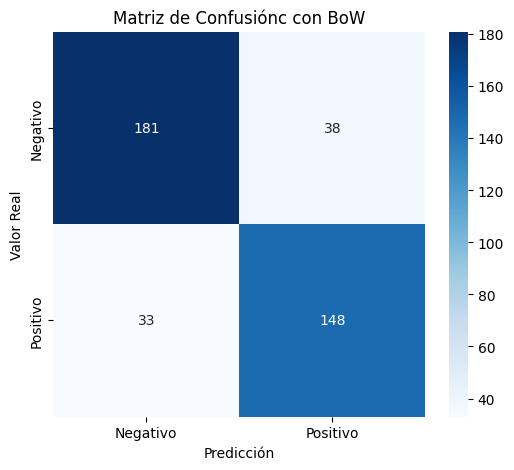

In [41]:
# 1. Matriz de confusión

# La Matriz de Confusión es útil para Muestra los aciertos y errores del modelo organizados por clase.

cm1 = confusion_matrix(y_test, y_pred_log_reg_Bow)
labels = ['Negativo', 'Positivo']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusiónc con BoW')
plt.show()

No hubo cambios respecto a la evaluación realiza en el modelo usando TF-IDF

Curva ROC AUC.

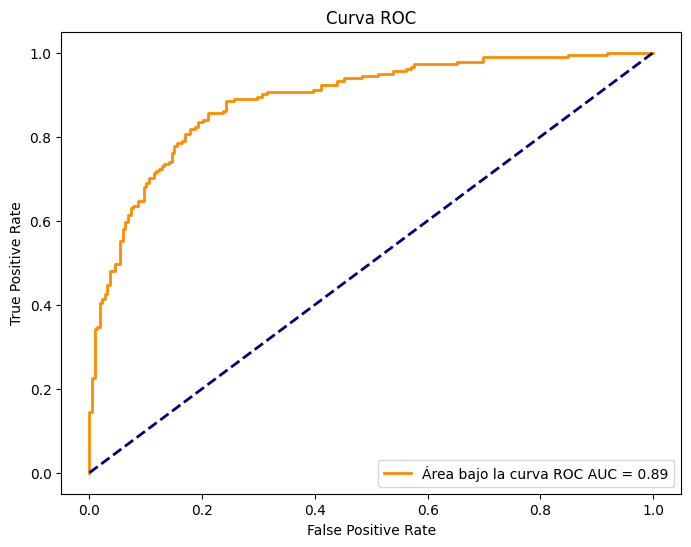

In [42]:
# 2. Curva ROC
# ROC AUC SCORE evalúa qué tan bien el modelo separa las clases.
fpr1, tpr1, _ = roc_curve(y_test, model_log_reg_Bow.decision_function(X_test_bow))
roc_auc1 = roc_auc_score(y_test, model_log_reg_Bow.decision_function(X_test_bow))

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Área bajo la curva ROC AUC = {roc_auc1:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

No hubo cambios respecto a la evaluación realiza en el modelo usando TF-IDF

Métricas de Predicción.

In [43]:
# 3. Métricas
# Accuracy:Para medir qué tan bien predice el modelo en datos nuevos (exactitud).
# Accuracy mide el porcentaje total de predicciones correctas sobre el total de casos.
accuracy = accuracy_score(y_test, y_pred_log_reg)
# Precision: Para medir el costo de un falso positivo es alto (por ejemplo, recomendar una película mala como buena).
# Precision mide qué proporción de las predicciones positivas hechas por el modelo son realmente positivas.
precision = precision_score(y_test, y_pred_log_reg)
# Recall: Para medir cuántos de los casos positivos reales fueron capturados por el modelo.
recall = recall_score(y_test, y_pred_log_reg)
# f1 Score: Para medir el promedio armónico entre precisión y recall. Un buen balance si ambas cosas son importantes.
f1 = f1_score(y_test, y_pred_log_reg)

print("Métricas de desempeño del modelo:")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

Métricas de desempeño del modelo:
Accuracy : 0.82
Precision: 0.80
Recall   : 0.82
F1 Score : 0.81


Validación Cruzada con BoW.

In [44]:
# Pipeline con Bag of Words y Regresión Logística
pipeline1 = make_pipeline(
    CountVectorizer(max_features=5000),  # Bag of Words
    LogisticRegression()
)

# Validación cruzada con 5 particiones
scores = cross_val_score(pipeline1, df['Comentario'], df['Valor'], cv=5, scoring='accuracy')

# Resultados
print(f"Precisión media con validación cruzada (BoW): {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")

Precisión media con validación cruzada (BoW): 0.811
Desviación estándar: 0.016


Se observa una mejora mínima de la precisión y la desviación estándar.

Los valores obtenidos usando TF-IDF fueron:

Precisión = 0,807

Desviación estándar = 0,018

## Redes Neuronales.

### Prueba de Modelo con Keras.

Vectorizar los textos

Se convierten los comentarios en una matriz numérica de hasta 10.000 características, considerando unigramas y bigramas.

Esto captura no solo palabras individuales, sino también combinaciones frecuentes de dos palabras, lo cual mejora la capacidad del modelo para captar expresiones útiles como “muy bueno” o “no sirve”.

In [45]:
# Vectorizar los textos
vectorizer_Neuro = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X = vectorizer_Neuro.fit_transform(df['Comentarios_sin_StopWords_str']).toarray()

Variable objetivo

Se extrae la variable objetivo desde la columna 'Valor' del DataFrame df, y se convierte en un array de NumPy para usarlo en el modelo de Machine Learning.

In [46]:
# Variable objetivo
y = df['Valor'].values

Separación del dataset en 80% entrenamiento y 20% validación, estratificando por clase para mantener la proporción de etiquetas (positivo/negativo).

In [47]:
# Dividir en train y test (estratificado)
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Modelo de red neuronal secuencial:

Capa 1: 128 neuronas con ReLU + Dropout (50%)

Capa 2: 64 neuronas con ReLU + Dropout (30%)

Capa de salida: 1 neurona con sigmoide, ideal para clasificación binaria.

Compilación:

Se usa binary_crossentropy como función de pérdida.

Métrica: precisión (accuracy).

Optimizador: Adam con learning_rate=0.001

In [48]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train1.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # 1 neurona y activación sigmoid para binario

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',   # función para binaria
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Resumen del modelo:

Resumen estructurado del modelo de red neuronal que acabás de construir con Keras. Esta salida es muy útil para entender la arquitectura y verificar que el modelo esté correctamente configurado.

In [49]:
# Mostramos el resumen del modelo: esto nos dará detalles sobre cada capa y el número de parámetros entrenables en el modelo.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

EarlyStopping para evitar sobreentrenamiento

El bloque implementa una técnica de regularización llamada Early Stopping, que detiene automáticamente el entrenamiento del modelo cuando la pérdida en el conjunto de validación (val_loss) deja de mejorar durante un número determinado de épocas.

Esto ayuda a prevenir el sobreajuste, es decir, que el modelo aprenda demasiado los datos de entrenamiento y pierda capacidad de generalización.

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use X_train1 and y_train1 which were specifically prepared for the neural network
history = model.fit(X_train1, y_train1,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=10,
                    callbacks=[early_stop])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5144 - loss: 0.6905 - val_accuracy: 0.6375 - val_loss: 0.6480
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7966 - loss: 0.5095 - val_accuracy: 0.7750 - val_loss: 0.4780
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9603 - loss: 0.1378 - val_accuracy: 0.7900 - val_loss: 0.4914
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9860 - loss: 0.0459 - val_accuracy: 0.7725 - val_loss: 0.5345
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9908 - loss: 0.0229 - val_accuracy: 0.7700 - val_loss: 0.5655
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9947 - loss: 0.0099 - val_accuracy: 0.7700 - val_loss: 0.6013
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9952 - loss: 0.0137 - val_accuracy: 0.7750 - val_loss: 0.6075


Matriz de Confusión.

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_val) > 0.5).astype("int32")

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[173  27]
 [ 63 137]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       200
           1       0.84      0.69      0.75       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.77       400
weighted avg       0.78      0.78      0.77       400



Precisión para clase 1 (0.84): cuando el modelo predice "positivo", acierta el 84% de las veces.

Recall para clase 1 (0.69): de todos los comentarios realmente positivos, el modelo detecta correctamente el 69%. Esto indica que se le escapan varios positivos.

Recall para clase 0 (0.86): el modelo detecta muy bien los negativos.

F1-score más bajo en clase 1 (0.75): el modelo tiene más dificultades en predecir correctamente los positivos.



📊 Gráfico de Accuracy y Loss por Época

Si las curvas de entrenamiento y validación están muy separadas, puede haber overfitting.

Si ambas curvas bajan y se estabilizan juntas, el modelo generaliza bien.

EarlyStopping puede cortar las épocas antes de 100, por eso es clave ver hasta dónde llegó realmente.


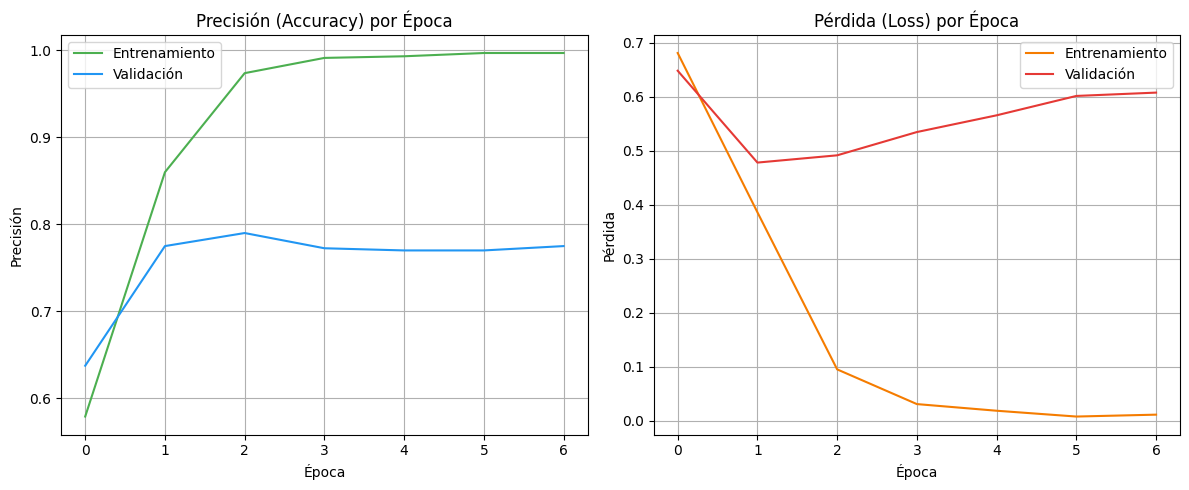

In [52]:
# Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='#4caf50')
plt.plot(history.history['val_accuracy'], label='Validación', color='#2196f3')
plt.title('Precisión (Accuracy) por Época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='#f57c00')
plt.plot(history.history['val_loss'], label='Validación', color='#e53935')
plt.title('Pérdida (Loss) por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📈 Análisis del gráfico de Precisión (Accuracy)
La precisión de entrenamiento sube rápidamente y alcanza casi el 100% en pocas épocas.

En cambio, la precisión de validación se estabiliza alrededor del 77%–79%, sin seguir la mejora del entrenamiento.

📌 Conclusión: Esto indica que el modelo está sobreajustando (overfitting): aprende muy bien los datos de entrenamiento, pero pierde capacidad de generalización.

📉 Análisis del gráfico de Pérdida (Loss)
La pérdida en entrenamiento cae bruscamente y casi llega a cero.

La pérdida de validación baja al principio pero luego empieza a subir desde la época 2–3.

📌 Conclusión: Otro signo claro de overfitting. El modelo memoriza los datos de entrenamiento y comienza a equivocarse más en datos nuevos (validación).

✅ ¿Qué se prodría hacer para mejorar?
Aumentar regularización:

Aumentar el Dropout (actualmente se tiene 0.5 y 0.3).

Agregar L2 regularization (penalización en los pesos).

Reducir complejidad del modelo:

Menos neuronas o capas.

El modelo podría ser demasiado complejo para el tamaño de tu dataset.

Más datos o data augmentation: ayuda a reducir el overfitting.

EarlyStopping está funcionando bien: cortó el entrenamiento antes de que empeore más.

Probar un modelo clásico (Logistic Regression, SVM) como comparación. A veces rinden igual o mejor con TF-IDF.



In [53]:
loss, accuracy = model.evaluate(X_train1, y_train1, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))


Precisión Entrenamiento: 0.9781
Precisión Prueba:  0.7750


Evaluación del modelo.

Evaluación del modelo con una reseña real del conjunto de datos.

Se muestra cómo el modelo clasifica una reseña individual y compara su predicción con la realidad

In [54]:
# Paso 1: Seleccionar una reseña real del DataFrame
indice = 1000  # Cambiar este número si se quiere ver otra reseña

oracion_real = df['Comentario'].iloc[indice]
valoracion_real = df['Valor'].iloc[indice]

nueva_reseña_vectorizada = vectorizer_Neuro.transform([oracion_real])

# Paso 2: Predecir con el modelo

nueva_reseña_vectorizada_dense = nueva_reseña_vectorizada.toarray()

prediccion = model.predict(nueva_reseña_vectorizada_dense)

# Paso 3: Convertir la probabilidad a clase 0 o 1
valoracion_predicha = 1 if prediccion[0][0] >= 0.5 else 0

# Paso 6: Mostrar resultados
print(f"Reseña: {oracion_real}")
print(f"Valoración real: {valoracion_real}")
print(f"Valoración predicha: {valoracion_predicha}")
print(f"Probabilidad predicha: {prediccion[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Reseña: Buen caso, excelente valor.
Valoración real: 1
Valoración predicha: 1
Probabilidad predicha: 0.9889


Test del modelo con frases nuevas.

In [55]:
# Testeamos con nuevas oraciones

# Definir una nueva oración para predecir.
nueva_oracion = ["si es fatal"]

nueva_secuencia_vectorizada = vectorizer_Neuro.transform(nueva_oracion)

# Convertir a array denso si el modelo lo espera
nueva_secuencia_vectorizada_dense = nueva_secuencia_vectorizada.toarray()


# Usar el modelo para predecir la valoración (0 o 1)

prediccion = model.predict(nueva_secuencia_vectorizada_dense)

print(f"Predicción: {prediccion[0][0]}")
valoracion = 1 if prediccion[0][0] >= 0.5 else 0
print(f"Valoración predicha: {valoracion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicción: 0.030454441905021667
Valoración predicha: 0


In [56]:
# X ahora contiene un array de secuencias numéricas (en formato tensor o matriz), en las que cada número representa un índice de palabra del vocabulario.
# Estas secuencias están ajustadas para tener la misma longitud (max_len=100), con las más largas recortadas y las más cortas rellenadas con ceros.
# Visualizamos el tipo de dato que es X
print(type(X))

print(X)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# **Conclusiones.**

A lo largo del trabajo se probaron distintos métodos de preprocesamiento para textos, aplicados a un análisis de sentimientos.
Dentro del análizsis de sentimiento se evaluaron los comentarios con baja probabilidad de predicción. Esto nos va a permitir visualizar la sintaxis de estos y tomar decisiones a la hora de mejorar el modelo.
Como futuras lineas, se puede re entrenar el modelo evaluando estas oraciones para que interprete mejor los sentiminetos.

Se trabajó con técnicas como Bag of Words y TF-IDF, y también se exploró un modelo más avanzado basado en Deep Learning usando Keras.

Se entrenaron tres modelos de machine learning con estas representaciones, y el que mejor funcionó fue el que utilizó TF-IDF, mostrando buenos resultados en la clasificación de sentimientos. En cambio, el modelo de Deep Learning no tuvo el rendimiento esperado, probablemente porque faltó ajustar mejor los parámetros y también porque el volumen de datos no era muy grande.

Como posible línea futura, se puede seguir probando con el modelo de Deep Learning, ajustando hiperparámetros (como incluir regularización L2, capas LSTM, etc.) y entrenando con una mayor cantidad de datos, lo cual podría mejorar bastante los resultados.